In [7]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

In [12]:
class RBFKernel:
    def __init__(self, X, sigma):
        self.sigma2 = sigma**2
        self.X = X
        self.values_ = np.empty((X.shape[0], X.shape[0]))
        
    def value(self, i, j):
        return np.exp(-((self.X[i, :] - self.X[j, :])**2).sum()
                      / (2 * self.sigma2))
    
    def eval(self, Z, s):
        return np.exp(-((self.X[s, np.newaxis, :]
                         - Z[np.newaxis, :, :])**2).sum(axis=2)
                      / (2*self.sigma2))                      

In [13]:
class KernelSVC:
    def __init__(self, C=1., sigma=1., max_iter=10000):
        self.C = C
        self.sigma = sigma
        self.max_iter = max_iter
        
    def fit(self, X, y, selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        kernel = RBFKernel(X, self.sigma)
        indices = np.arange(X.shape[0])
        for _ in range(self.max_iter):
            s = a != 0.
            ydf = y * (1 - y * np.dot(a[s]*y[s],
                                      kernel.eval(X, s)).T)
            iydf = np.c_[indices, ydf]
            
            # i, jを取り出す
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) | 
                             ((a < self.C) & (y < 0))],
                        key = itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) | 
                             ((a < self.C) & (y > 0))],
                        key = itemgetter(1))[0])

            # iにおける最小値 > jにおける最大値の条件を満たしていたらiterationを終了する
            if ydf[i] >= ydf[j]:
                break
            
            # 効率よく計算するために，更新されたaの差分だけを計算している
            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            
            # kernel関数の計算（本来これは毎iterationで計算する必要はない）
            kii = kernel.value(i, i)
            kij = kernel.value(i, j)
            kjj = kernel.value(j, j)
            
            s = a != 0.
            s[i] = False
            s[j] = False
            
            kxi = kernel.eval(X[i, :].reshape(1, -1), s).ravel()
            kxj = kernel.eval(X[j, :].reshape(1, -1), s).ravel()
            
            ai = ((1 - y[i]*y[j]
                   + y[i]*((kij - kjj)*ay2
                           - (a[s]*y[s]*(kxi-kxj)).sum()))
                   / (kii + kjj - 2*kij))

            # ai < 0だったらai = 0が実質最適解
            if ai < 0:
                ai = 0
            # ai > Cだったら ai = C が実質最適解
            elif ai > self.C:
                ai = self.C
            aj = (-ai * y[i] - ay2) * y[j]
            
            # aj< 0だったらaj = 0が実質最適解
            if aj < 0:
                aj = 0
                ai = (-aj * y[j] - ay2) * y[j]
            # ai > Cだったら ai = C が実質最適解
            elif aj > self.C:
                aj = self.C
                ai = (-aj * y[j] - ay2) * y[j]
                
            # 計算の効率化のために，ayとayxをi, jの変更による差分だけで更新
            ay += y[i]*(ai - a[i]) + y[j]*(aj - a[j])
            
            # ai<0だったらai=0(ajも同様）にするのを繰り返し行うため，もしも前回と結果が一致していたらiterationを終了する
            if ai == a[i]:
                break
            
            a[i] = ai
            a[j] = aj
            
        self.a_ = a
        self.y_ = y
        self.kernel_ = kernel
        s = a != 0.
        self.w0_ = (y[s]
                    - np.dot(a[s]*y[s],
                             kernel.eval(X[s], s))).sum() / s.sum()
        with open('svm.log', 'w') as fp:
            print(a, file=fp)
            
    def predict(self, X):
        s = self.a_ != 0.
        return np.sign(self.w0_
                       + np.dot(self.a_[s]*self.y_[s],
                                self.kernel_.eval(X, s)))

In [14]:
def rbf_classify(seed, num, dim=2):
    plt.axes().set_aspect('equal')
    
    # create random data
    np.random.seed(seed)
    X0 = np.random.randn(num, dim)
    X1 = np.random.randn(num, dim) + np.array([2.5 + 0.5*i for i in range(dim)])
    y = np.array([1] * num + [-1] * num)
    
    X = np.r_[X0, X1]

    # define the model
    model = KernelSVC()
    model.fit(X, y)
    
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()
    
    # visualize the random data
    plt.scatter(X0[:, 0], X0[:, 1], color='k', marker='+')
    plt.scatter(X1[:, 0], X1[:, 1], color='k', marker='*')
    
    xmesh, ymesh = np.meshgrid(np.linspace(xmin, xmax, 200),
                               np.linspace(ymin, ymax, 200))
    Z = model.predict(np.c_[xmesh.ravel(),
                            ymesh.ravel()]).reshape(xmesh.shape)
    
    plt.contour(xmesh, ymesh, Z, levels=[0], colors='k')

    def f(model, x):
        return (-model.w0_ - model.w_[0] * x) / model.w_[1]
    
    plt.show()

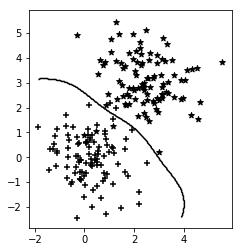

In [15]:
rbf_classify(1, 100)

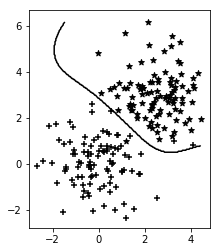

In [16]:
rbf_classify(2, 100)